# Lab 1

## Part 2: Neural Machine Translation in the wild
In the second part of the homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.
* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* or just fine-tunning BERT)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__
Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [31]:
! pip  install subword-nmt
! pip install nltk
! pip install torchtext
! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/Lab1_NLP/data.txt
! pip install https://github.com/rsennrich/subword-nmt/archive/master.zip
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

  Created wheel for subword-nmt: filename=subword_nmt-0.3.7-cp36-none-any.whl size=25140 sha256=04913b4730653f9993b354cc90e6a4965cf12fb5bd1e70bb123e8e4e6320c7a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-f1vjgoq9/wheels/f8/96/2f/67d2f7991a593e6f63468df1a71368ee07287c4006858a16e0
Successfully built subword-nmt
--2020-05-02 15:08:22--  https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/Lab1_NLP/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt.2’

data.txt.2          100%[===================>]  12.31M  28.2MB/s    in 0.4s    

2020-05-02 15:08:23 (28.2 MB/s) - ‘data.txt.2’ saved [12905334/12905334]

  Using cached https://github.com/rsennrich/subword-nmt/archive/master.zip
  Created wh

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [0]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [0]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [0]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [36]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [37]:
print(vars(train_data.examples[0]))

{'trg': ['all', 'accommodation', 'at', 'rey', 'carlos', 'offers', 'views', 'from', 'the', 'private', 'terrace', '.'], 'src': ['с', 'собственных', 'террас', 'всех', 'номеров', 'отеля', 'rey', 'carlos', 'открывается', 'прекрасный', 'вид', '.']}


In [0]:
# prepare data for bpe
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in train_data.examples:
        src_line, dst_line = line.src, line.trg
        src_line = ''.join(map(str, src_line))
        dst_line = ''.join(map(str, dst_line))
        f_src.write(src_line + '\n')
        f_dst.write(dst_line + '\n')

In [0]:
# Build vocabulary
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=5000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

In [0]:
# Apply bpe and prepare data
for dataset in [train_data, valid_data, test_data]:
    for line in dataset:
        line.src = " ".join(map(str, line.src))
        
        line.src = (bpe['en'].process_line(line.src)).split(" ")
        
        line.trg = " ".join(map(str, line.trg))
      
        line.trg = (bpe['ru'].process_line(line.trg)).split(" ")
        

In [0]:

#for dataset in [train_data, valid_data, test_data]:
    #for line in dataset:
      #line.src = " ".join(map(str, line.src))
      #line.src = line.src.replace('@@', '')
      #line.src = (line.src).split(" ")
      #line.trg = " ".join(map(str, line.trg))
      #line.trg = line.trg.replace('@@', '')
      #line.trg = (line.trg).split(" ") 

      

In [0]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [43]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 14128
Unique tokens in target (en) vocabulary: 10139


Here are tokens from original (RU) corpus:

In [44]:
SRC.vocab.itos[::1000]

['<unk>',
 'морепродуктов',
 'балатон',
 'краби',
 'emerald',
 'эксетер',
 'palme',
 'функциональной',
 'диагорас',
 'таверна',
 'madame',
 'варочными',
 'кутб',
 'присмотра',
 'шезлонгов']

"And from target (EN) corpus:

In [0]:
TRG.vocab.itos[::1000]

And here is example from train dataset:

In [0]:
print(vars(train_data.examples[9]))

Let's check the length distributions:

In [0]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

In [0]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [46]:
device

device(type='cuda')

In [47]:
len(SRC.vocab)

14128

In [0]:


BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort = False)

In [0]:
submission_dataset = next(iter(test_iterator))

In [50]:
import modules_

import imp
imp.reload(modules_)

Encoder = modules_.Encoder
Attention = modules_.Attention
DecoderWithAttention = modules_.DecoderWithAttention
Seq2Seq = modules_.Seq2Seq
SRC.vocab, TRG.vocab

(<torchtext.vocab.Vocab at 0x7f69035efc88>,
 <torchtext.vocab.Vocab at 0x7f69035efbe0>)

In [51]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
attention = Attention(HID_DIM, HID_DIM)
dec = DecoderWithAttention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, HID_DIM, DEC_DROPOUT, attention)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

def init_weights(m):
    # init weights for the nn from uniform distribution (refer to the week03 practice for hint)
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

optimizer = optim.Adam(model.parameters())

PAD_IDX = TRG.vocab.stoi['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [52]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,271,323 trainable parameters


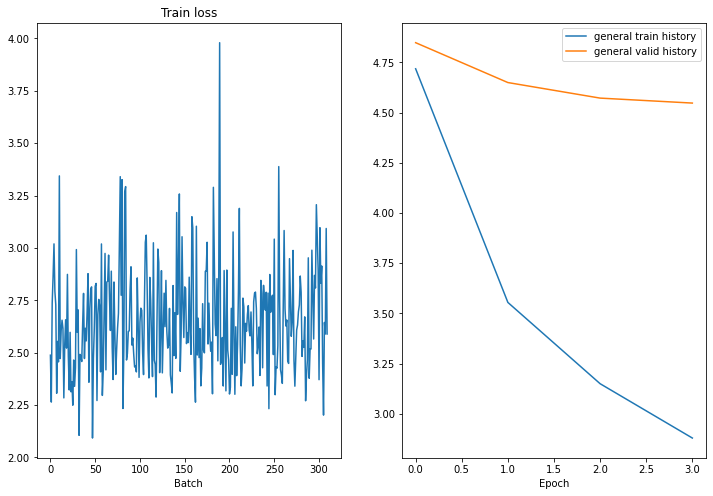

Epoch: 05 | Time: 3m 50s
	Train Loss: 2.647 | Train PPL:  14.108
	 Val. Loss: 4.481 |  Val. PPL:  88.319
| Test Loss: 4.532 | Test PPL:  92.987 |


In [20]:
train_history = []
valid_history = []

N_EPOCHS = 5
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

model.load_state_dict(torch.load('tut1-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

__Let's take a look at our network quality__:

In [21]:
! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/Lab1_NLP/utils.py

--2020-05-02 14:38:19--  https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/Lab1_NLP/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 908 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     908  --.-KB/s    in 0s      

2020-05-02 14:38:19 (58.9 MB/s) - ‘utils.py’ saved [908/908]



In [0]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [0]:
batch = next(iter(test_iterator))

In [0]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [0]:
import tqdm

In [27]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:13,  4.34it/s]


In [0]:
def undo_text(original_text):
  original = []


  b = ''
    
  i = 0   
  while i < len(original_text):
    while original_text[i][-1]=='@':
      
    
      b += original_text[i].replace('@','')
      i +=1
    else:
      b += original_text[i]
      original.append(b)
      b = ''
      i = i+1
  return original

In [0]:
generated_text = undo_text(generated_text)
original_text = undo_text(original_text)

In [28]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

20.501764872267117

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points

Summary:

---


При выполнении данной лабы использовались: 


*   Transformer(Harvard implementation, includes Multi-head attention, positional encoding)
*   BPE
*   Attention

Blue-score:
*   Transformer without BPE: 18.7
*   Transformer + BPE: 19.7
*   Attention: 20.5


Complexity of the models(number of trainable parameters):

*   Transformer without BPE: 61,804,965 trainable parameters
*   Transformer + BPE: 61,772,201 trainable parameters
*   Attention: 23,271,323 trainable parameters





thoughts:
также пробовал attention+bpe, но не смог справиться с ошибкой cuda out of memory, видимо bpe сильно усложняет обучение, несмотря на понижение размерности словаря.

BPE повышает качество перевода, но сильно усложняет обучение.
Относительно низкий результат трансформера может быть связан с некорректной реализацией на данном датасете и маленьким словарем.











